# 2020 Cheseapeake Bay Hackathon -
indicator: water temperature |
mapping time-span: 2015 - 2020

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ftplib
import io
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [82]:
ftp = ftplib.FTP("ftp.nodc.noaa.gov")
ftp.login()

'230 Login successful.'

In [83]:
ftp.cwd("nodc/archive/arc0135/0187718/2.2/data/0-data/")
ftp.nlst()
download_file = io.BytesIO()
ftp.retrbinary('RETR lake_erie_habs_field_sampling_results_2012_2018_v2.csv', download_file.write)
download_file.seek(0)
data = pd.read_csv(download_file, engine='python', encoding = "ISO-8859-1")
ftp.quit()

'221 Goodbye.'

In [2]:
import geopandas as gpd

In [85]:
cd "..\Bay Project\Data\WBD_National_GDB\"

C:\Users\jchen148.UR\Documents\Bay Project\Data\WBD_National_GDB


In [4]:
huc_12 = gpd.read_file("WBD_National_GDB.gdb", driver='FileGDB', layer='WBDHU12')

In [5]:
huc_12

tnmid  \
0       {AAF0D733-828B-4B8E-9E52-388A49AC0A23}   
1       {FEEC96BB-D4C0-468F-A345-6996A458D7A7}   
2       {5954C8E6-710A-4F46-9409-C39F7A4E8031}   
3       {DF84FD2E-015D-4B39-9409-68BAF583D58C}   
4       {D64CC50D-33CD-43A1-8FED-A43524B2A383}   
...                                        ...   
102903  {0E0F3DE6-1419-4E79-96B1-2BD90CFA5036}   
102904  {CB049C8F-AD12-41D1-A988-6F7376E740A2}   
102905  {0FC28768-98FF-4BB3-9A59-4BB38BD3CF02}   
102906  {35E8E9DA-A9F9-4FE8-9D39-6BAF2F2FD363}   
102907  {D3B03947-5815-47FD-94DF-CA8DEB6D527D}   

                                  metasourceid sourcedatadesc  \
0       {33EA2180-A425-4AE6-951F-ABCBBF25B893}           None   
1       {33EA2180-A425-4AE6-951F-ABCBBF25B893}           None   
2       {33EA2180-A425-4AE6-951F-ABCBBF25B893}           None   
3       {33EA2180-A425-4AE6-951F-ABCBBF25B893}           None   
4       {33EA2180-A425-4AE6-951F-ABCBBF25B893}           None   
...                                        ...            ...   
102903                                                   None   
102904                                                   None   
102905                                                   None   
102906                                                   None   
102907                                                   None   

       sourceoriginator sourcefeatureid             loaddate  \
0                  None            None  2017-05-25T09:05:31   
1                  None            None  2017-05-25T09:05:42   
2                  None            None  2017-05-25T09:05:42   
3                  None            None  2017-05-25T09:05:42   
4                  None            None  2017-05-25T09:05:42   
...                 ...             ...                  ...   
102903             None            None  2020-08-19T07:45:29   
102904             None            None  2020-08-19T07:45:29   
102905             None            None  2020-08-19T07:45:29   
102906             None            None  2020-08-19T07:45:29   
102907             None            None  2020-08-19T07:45:29   

        noncontributingareaacres  noncontributingareasqkm  areasqkm  \
0                            0.0                      0.0     53.46   
1                            0.0                      0.0     42.55   
2                            0.0                      0.0     62.97   
3                            0.0                      0.0     82.87   
4                            0.0                      0.0    101.75   
...                          ...                      ...       ...   
102903                       0.0                      0.0    128.77   
102904                       0.0                      0.0     88.60   
102905                       0.0                      0.0     70.06   
102906                       0.0                      0.0    121.20   
102907                       0.0                      0.0     97.28   

        areaacres  ...                                               name  \
0        13211.47  ...                     Judicial Ditch Number Thirteen   
1        10514.34  ...                    West Branch Lac qui Parle River   
2        15561.22  ...                     County Ditch Number Thirtyfour   
3        20477.59  ...                   County Ditch Number Twentynine A   
4        25142.88  ...  County Ditch Number Seventynine-Lac qui Parle ...   
...           ...  ...                                                ...   
102903   31819.10  ...                               Outlet Avingak Creek   
102904   21893.04  ...                           Headwaters Avingak Creek   
102905   17312.40  ...                                       190601020601   
102906   29949.22  ...                                       190601020602   
102907   24039.41  ...                         190601020603-Kokolik River   

       states         huc12 hutype humod         tohuc  \
0       IA,MN  070200090402      S    NM  070200090403

In [6]:
import pandas as pd
import fiona
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from pyproj import Proj
import geoplot as gplt
import geoplot.crs as gcrs

In [7]:
# converting to lat long
huc_12.crs = {'init' :'epsg:2283'}

C:\Users\jchen148.UR\.conda\envs\tensorflow_cpu\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [9]:
bay_states = ['NY', 'PA', 'VA', 'MD', 'WV', 'DE', 'DC']

In [12]:
keep = []
for i in bay_states:
    for x in huc_12['states'].unique():
        if str(x) in i:
            keep.append(x)
print(keep)

['NY', 'PA', 'VA', 'MD', 'WV', 'DE']


In [13]:
keephuc = huc_12[huc_12['states'].isin(keep)]

In [14]:
keephuc.shape

(4663, 21)

In [15]:
keephuc['states'].unique()

array(['WV', 'VA', 'DE', 'MD', 'PA', 'NY'], dtype=object)

In [16]:
keephuc.head(2)

tnmid  \
232  {BC75B77F-95EE-45C0-91E9-D373EA3D6BAD}   
236  {0432273F-E9E0-4FC4-80AA-9ADDB0A272EC}   

                               metasourceid sourcedatadesc sourceoriginator  \
232  {7E9D2B22-BF65-426E-9174-661A4609B6FA}           None             None   
236  {7E9D2B22-BF65-426E-9174-661A4609B6FA}           None             None   

    sourcefeatureid             loaddate  noncontributingareaacres  \
232            None  2017-05-25T13:11:27                       0.0   
236            None  2017-05-25T13:11:27                       0.0   

     noncontributingareasqkm  areasqkm  areaacres  ...  \
232                      0.0    103.96   25688.66  ...   
236                      0.0    106.99   26436.85  ...   

                                       name states         huc12 hutype humod  \
232                Headwaters Elkhorn Creek     WV  050702010202      S    NM   
236  East Wilderness Creek-Kimberling Creek     VA  050500020103      S    NM   

            tohuc                                globalid shape_Length  \
232  050702010203  {AAFE631D-E29C-11E2-8094-0021280458E6}     0.534342   
236  050500020105  {B33FB818-E29C-11E2-8094-0021280458E6}     0.532044   

     shape_Area                                           geometry  
232    0.010579  MULTIPOLYGON (((-81.39507 37.46196, -81.39492 ...  
236    0.010856  MULTIPOLYGON (((-81.03335 37.23799, -81.03275 ...  

[2 rows x 21 columns]

Read in County

In [18]:
import pandas as pd
import fiona
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from pyproj import Proj
import geoplot as gplt
import geoplot.crs as gcrs

In [19]:
# read in county boundaries
counties = gpd.read_file('tl_2017_us_county.shp')

In [21]:
state_fipscode = pd.read_csv("https://gist.githubusercontent.com/dantonnoriega/bf1acd2290e15b91e6710b6fd3be0a53/raw/11d15233327c8080c9646c7e1f23052659db251d/us-state-ansi-fips.csv")

In [22]:
state_fipscode.columns

Index(['stname', ' st', ' stusps'], dtype='object')

In [23]:
state_fipscode.columns = ['stname', 'st', 'stusps']

In [24]:
state_fipscode['fips'] = ['0' + str(i) if len(str(i)) == 1 else str(i) for i in state_fipscode['st']]

In [25]:
state_fipscode

stname  st stusps fips
0                Alabama   1     AL   01
1                 Alaska   2     AK   02
2                Arizona   4     AZ   04
3               Arkansas   5     AR   05
4             California   6     CA   06
5               Colorado   8     CO   08
6            Connecticut   9     CT   09
7               Delaware  10     DE   10
8   District of Columbia  11     DC   11
9                Florida  12     FL   12
10               Georgia  13     GA   13
11                Hawaii  15     HI   15
12                 Idaho  16     ID   16
13              Illinois  17     IL   17
14               Indiana  18     IN   18
15                  Iowa  19     IA   19
16                Kansas  20     KS   20
17              Kentucky  21     KY   21
18             Louisiana  22     LA   22
19                 Maine  23     ME   23
20              Maryland  24     MD   24
21         Massachusetts  25     MA   25
22              Michigan  26     MI   26
23             Minnesota  27     MN   27
24           Mississippi  28     MS   28
25              Missouri  29     MO   29
26               Montana  30     MT   30
27              Nebraska  31     NE   31
28                Nevada  32     NV   32
29         New Hampshire  33     NH   33
30            New Jersey  34     NJ   34
31            New Mexico  35     NM   35
32              New York  36     NY   36
33        North Carolina  37     NC   37
34          North Dakota  38     ND   38
35                  Ohio  39     OH   39
36              Oklahoma  40     OK   40
37                Oregon  41     OR   41
38          Pennsylvania  42     PA   42
39          Rhode Island  44     RI   44
40        South Carolina  45     SC   45
41          South Dakota  46     SD   46
42             Tennessee  47     TN   47
43                 Texas  48     TX   48
44                  Utah  49     UT   49
45               Vermont  50     VT   50
46              Virginia  51     VA   51
47            Washington  53     WA   53
48         West Virginia  54     WV   54
49             Wisconsin  55     WI   55
50               Wyoming  56     WY   56

In [26]:
state_fipscode['stusps'] = state_fipscode['stusps'].apply(lambda x: x.strip())

In [27]:
state_fipscode['fips'] = state_fipscode['fips'].apply(lambda x: x.strip())

In [28]:
fipsdict = dict(zip(state_fipscode['fips'], state_fipscode['stusps']))

In [29]:
counties['state'] = counties['STATEFP'].map(fipsdict)
counties['fullfips'] = counties['STATEFP'] + counties['COUNTYFP']

In [30]:
counties.head()

STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD CLASSFP  \
0      31      039  00835841  31039     Cuming     Cuming County   06      H1   
1      53      069  01513275  53069  Wahkiakum  Wahkiakum County   06      H1   
2      35      011  00933054  35011    De Baca    De Baca County   06      H1   
3      31      109  00835876  31109  Lancaster  Lancaster County   06      H1   
4      31      129  00835886  31129   Nuckolls   Nuckolls County   06      H1   

   MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND    AWATER     INTPTLAT  \
0  G4020  None   None     None        A  1477641638  10701538  +41.9158651   
1  G4020  None   None     None        A   680956787  61588406  +46.2946377   
2  G4020  None   None     None        A  6016761648  29147345  +34.3592729   
3  G4020   339  30700     None        A  2169252486  22867561  +40.7835474   
4  G4020  None   None     None        A  1489645186   1718484  +40.1764918   

       INTPTLON                                           geometry state  \
0  -096.7885168  POLYGON ((-97.01952 42.00410, -97.01952 42.004...    NE   
1  -123.4244583  POLYGON ((-123.43639 46.23820, -123.44759 46.2...    WA   
2  -104.3686961  POLYGON ((-104.56739 33.99757, -104.56772 33.9...    NM   
3  -096.6886584  POLYGON ((-96.91060 40.95841, -96.91060 40.958...    NE   
4  -098.0468422  POLYGON ((-98.27367 40.08940, -98.27367 40.089...    NE   

  fullfips  
0    31039  
1    53069  
2    35011  
3    31109  
4    31129

In [31]:
counties.state.unique()

array(['NE', 'WA', 'NM', nan, 'SD', 'TX', 'CA', 'KY', 'OH', 'AL', 'GA',
       'WI', 'AR', 'OR', 'PA', 'MS', 'MO', 'CO', 'NC', 'UT', 'OK', 'VA',
       'TN', 'WY', 'WV', 'LA', 'NY', 'MI', 'IN', 'MA', 'KS', 'ID', 'FL',
       'AK', 'NV', 'IL', 'VT', 'CT', 'MT', 'NJ', 'MN', 'ND', 'MD', 'IA',
       'SC', 'ME', 'HI', 'NH', 'AZ', 'DE', 'DC', 'RI'], dtype=object)

In [32]:
keep_counties = counties[counties['state'].isin(bay_states)]

In [33]:
keep_counties.reset_index(inplace=True, drop=True)

In [34]:
keep_counties.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'state', 'fullfips'],
      dtype='object')

In [35]:
keep_counties.state.unique()

array(['PA', 'VA', 'WV', 'NY', 'MD', 'DE', 'DC'], dtype=object)

In [36]:
keep_counties.shape

(345, 20)

In [37]:
keep_counties.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'state', 'fullfips'],
      dtype='object')

In [35]:
keep_counties['state'].unique()

array(['PA', 'VA', 'WV', 'NY', 'MD', 'DE', 'DC'], dtype=object)

# plotting CBP and CMC water temperature maps

CBP

In [39]:
# read in the data
cbp_water = pd.read_excel("new_cbp_seasonal.xlsx")

In [40]:
cbp_water.columns

Index(['Agency', 'BiasPC', 'CloudCover', 'Comments', 'Cruise', 'Database',
       'Date', 'FieldActivityEventType', 'FieldActivityRemark', 'FlowStage',
       'GaugeHeight', 'GroupCode', 'HUC12', 'Lab', 'Latitude', 'Layer',
       'Longitude', 'LowerPycnocline', 'MeasureValue', 'Method',
       'ModifiedDate', 'Other Comments', 'Other Conditions', 'Parameter',
       'ParameterName_CBP', 'ParameterName_CMC', 'PrecipType', 'PrecisionPC',
       'Pressure', 'Problem', 'Program', 'Project', 'Qualifier', 'Rainfall',
       'Rainfall Within 24 Hours', 'Rainfall Within 48 Hours', 'SampleDepth',
       'SampleId', 'SampleReplicateType', 'SampleType', 'Sea State', 'Source',
       'Station', 'StationCode', 'StationName', 'Stream Flow', 'Tidal Stage',
       'TideStage', 'TierLevel', 'Time', 'TotalDepth', 'Unit',
       'UpperPycnocline', 'Water Color', 'Water Color Description',
       'Water Odor', 'Water Odor Description', 'Water Surfaces', 'WaveHeight',
       'Weather Conditions Day Before

In [41]:
cbp_water.Year.dtype

dtype('int64')

In [ ]:
# select Year as 2015 - 2020

In [187]:
cbp_water_recent = cbp_water[cbp_water.Year >= 2015]

In [188]:
cbp_water_recent.reset_index(inplace=True, drop=True)

In [232]:
cbp_water_2020_summer = cbp_water[(cbp_water.Year == 2020) & (cbp_water.Season == 'Summer')]

In [233]:
cbp_water_2020_summer.reset_index(inplace=True, drop=True)

In [234]:
cbp_water_2020_summer['Season']

0      Summer
1      Summer
2      Summer
3      Summer
4      Summer
        ...  
416    Summer
417    Summer
418    Summer
419    Summer
420    Summer
Name: Season, Length: 421, dtype: object

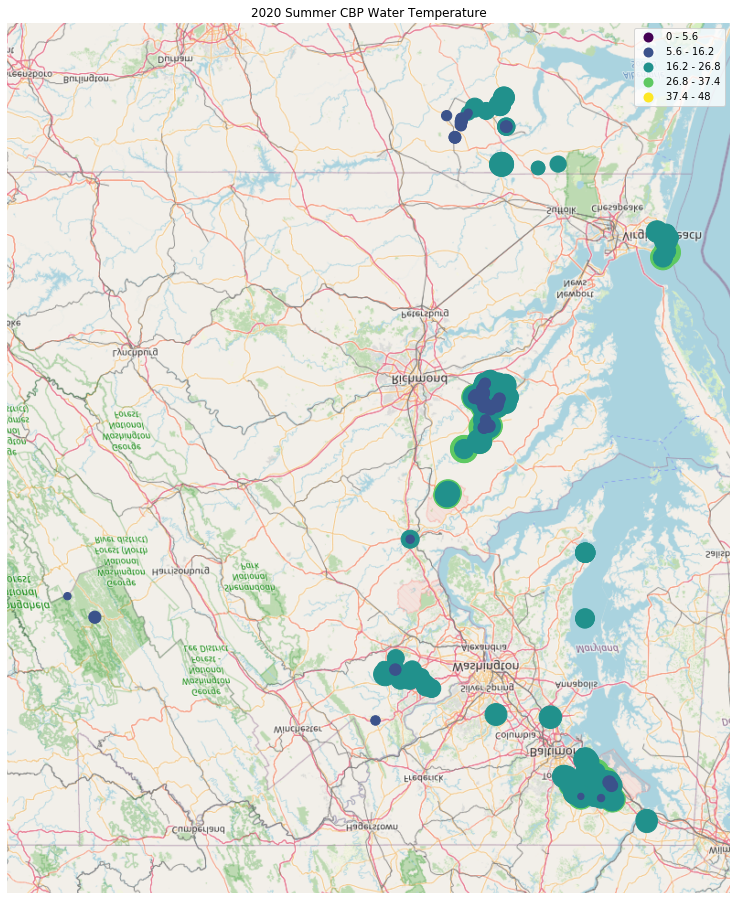

In [235]:
from shapely.geometry import Point
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import geoplot.crs as gcrs
import mapclassify as mc

gdf_cbp = geopandas.GeoDataFrame(
    cbp_water_2020_summer, geometry=geopandas.points_from_xy(cbp_water_2020_summer.Longitude, cbp_water_2020_summer.Latitude))

scheme = mc.EqualInterval(cbp_water_recent['MeasureValue'], k=5)
geometry = gdf_cbp['geometry']
crs = {'init' :'epsg:2283'}

ax = gplt.webmap(gdf_cbp, figsize = (16, 16), clip=geometry,
    shade=True, cmap='Reds', projection=gcrs.WebMercator())
gplt.pointplot(
    gdf_cbp,
    scale='MeasureValue', limits=(2, 30), projection=gcrs.AlbersEqualArea(),
    hue='MeasureValue',
    legend=True,
    scheme=scheme,
#    legend_var='scale',
#    legend_kwargs={'bbox_to_anchor': (1, 0.35), 'frameon': False},
#    legend_values=[0, 5, 10, 15, 20, 25, 30],
#    legend_labels=['0 Degree Celsius', '5 Degree Celsius', '10 Degree Celsius', '15 Degree Celsius', '20 Degree Celsius', \
#                  '25 Degree Celsius','30 Degree Celsius'],
    ax=ax
)
plt.title("2020 Summer CBP Water Temperature")
plt.savefig('2020 Summer CBP Water Temperature Heatmap.png')

In [176]:
scheme_2018_winter_cbp = scheme

In [177]:
scheme_2018_winter_cbp

EqualInterval         

   Interval      Count
----------------------
[-1.67,  3.39] |   131
( 3.39,  8.44] |   346
( 8.44, 13.49] |   283
(13.49, 18.55] |   131
(18.55, 23.60] |     4

In [182]:
scheme_2017_winter_cbp = scheme

In [183]:
scheme_2017_winter_cbp

EqualInterval         

   Interval      Count
----------------------
[-2.00,  1.98] |    60
( 1.98,  5.96] |   266
( 5.96,  9.94] |   277
( 9.94, 13.92] |    75
(13.92, 17.90] |    80

In [263]:
scheme_2020_winter_cbp # I can go back to this point to see if that was just typo

EqualInterval         

   Interval      Count
----------------------
[-5.00,  5.60] |  1986
( 5.60, 16.20] |  8179
(16.20, 26.80] | 11440
(26.80, 37.40] |  4213
(37.40, 48.00] |     9

CMC

In [106]:
# read in the data
cmc_water = pd.read_excel("new_cmc_seasonal.xlsx")

In [107]:
cmc_water.columns

Index(['Agency', 'BiasPC', 'CloudCover', 'Comments', 'Cruise', 'Database',
       'Date', 'FieldActivityEventType', 'FieldActivityRemark', 'FlowStage',
       'GaugeHeight', 'GroupCode', 'HUC12', 'Lab', 'Latitude', 'Layer',
       'Longitude', 'LowerPycnocline', 'MeasureValue', 'Method',
       'ModifiedDate', 'Other Comments', 'Other Conditions', 'Parameter',
       'ParameterName_CBP', 'ParameterName_CMC', 'PrecipType', 'PrecisionPC',
       'Pressure', 'Problem', 'Program', 'Project', 'Qualifier', 'Rainfall',
       'Rainfall Within 24 Hours', 'Rainfall Within 48 Hours', 'SampleDepth',
       'SampleId', 'SampleReplicateType', 'SampleType', 'Sea State', 'Source',
       'Station', 'StationCode', 'StationName', 'Stream Flow', 'Tidal Stage',
       'TideStage', 'TierLevel', 'Time', 'TotalDepth', 'Unit',
       'UpperPycnocline', 'Water Color', 'Water Color Description',
       'Water Odor', 'Water Odor Description', 'Water Surfaces', 'WaveHeight',
       'Weather Conditions Day Before

In [108]:
cmc_water.Year.head()

0    2012
1    2014
2    2014
3    2014
4    2014
Name: Year, dtype: int64

In [109]:
cmc_water.Season.head()

0    Winter
1    Winter
2    Winter
3    Winter
4    Winter
Name: Season, dtype: object

In [110]:
# select Year as 2015 - 2020

In [236]:
cmc_water_recent = cmc_water[cmc_water.Year >= 2015]

In [237]:
cmc_water_recent.reset_index(inplace=True, drop=True)

In [260]:
cmc_water_2015_summer = cmc_water[(cmc_water.Year == 2015) & (cmc_water.Season == 'Summer')]
cmc_water_2015_summer.reset_index(inplace=True, drop=True)
cmc_water_2015_summer['Season']

0      Summer
1      Summer
2      Summer
3      Summer
4      Summer
        ...  
805    Summer
806    Summer
807    Summer
808    Summer
809    Summer
Name: Season, Length: 810, dtype: object

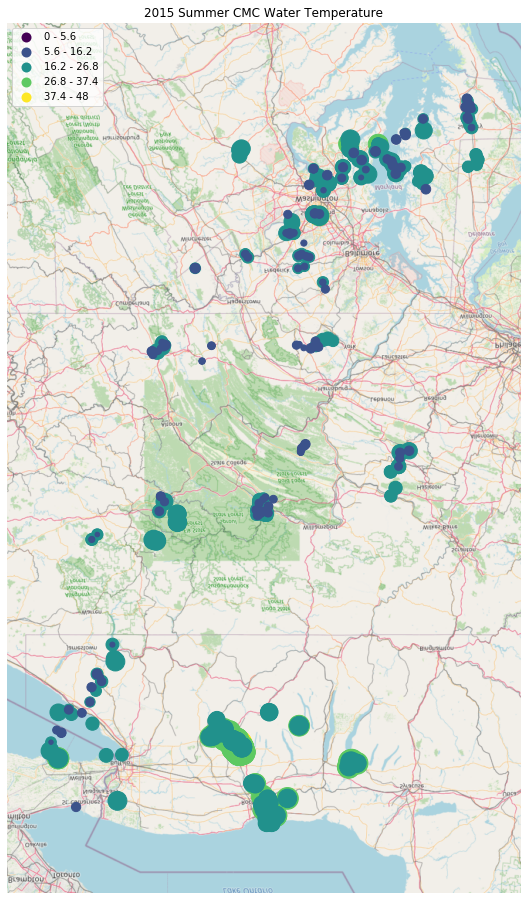

In [261]:
from shapely.geometry import Point
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import geoplot.crs as gcrs
import mapclassify as mc

gdf_cmc = geopandas.GeoDataFrame(
    cmc_water_2015_summer, geometry=geopandas.points_from_xy(cmc_water_2015_summer.Longitude, cmc_water_2015_summer.Latitude))

scheme = mc.EqualInterval(cmc_water_recent['MeasureValue'], k=5)
geometry = gdf_cmc['geometry']
crs = {'init' :'epsg:2283'}

ax = gplt.webmap(gdf_cmc, figsize = (16, 16), clip=geometry,
    shade=True, cmap='Reds', projection=gcrs.WebMercator())
gplt.pointplot(
    gdf_cmc,
    scale='MeasureValue', limits=(2, 30), projection=gcrs.AlbersEqualArea(),
    hue='MeasureValue',
    legend=True,
    scheme=scheme,
#    legend_var='scale',
#    legend_kwargs={'bbox_to_anchor': (1, 0.35), 'frameon': False},
#    legend_values=[0, 5, 10, 15, 20, 25, 30],
#    legend_labels=['0 Degree Celsius', '5 Degree Celsius', '10 Degree Celsius', '15 Degree Celsius', '20 Degree Celsius', \
#                  '25 Degree Celsius','30 Degree Celsius'],
    ax=ax
)
plt.title("2015 Summer CMC Water Temperature")
plt.savefig('2015 Summer CMC Water Temperature Heatmap.png')

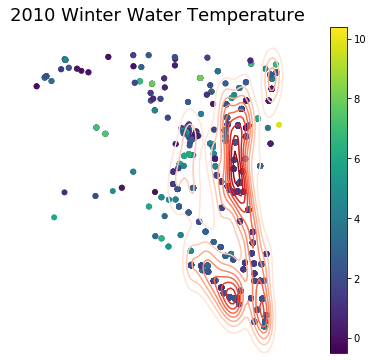

In [128]:
ax1 = gplt.kdeplot(gdf,projection=gcrs.AlbersEqualArea(), cmap='Reds')
gplt.pointplot(gdf, hue='MeasureValue', legend=True, ax=ax1)
plt.title('2010 Winter Water Temperature', fontsize=18)
plt.savefig("2010 Winter Water Temp.png", bbox_inches='tight', pad_inches=0.1)

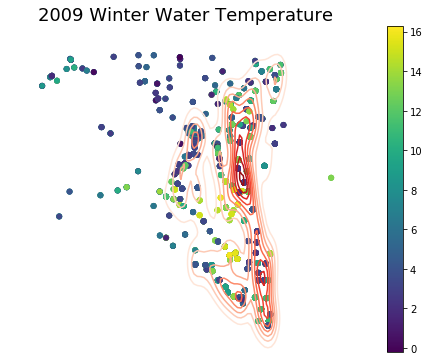

In [129]:
ax2 = gplt.kdeplot(gdf_win_2009,projection=gcrs.AlbersEqualArea(), cmap='Reds')
gplt.pointplot(gdf_win_2009, hue='MeasureValue', legend=True, ax=ax2)
plt.title('2009 Winter Water Temperature', fontsize=18)
plt.savefig("2009 Winter Water Temp.png", bbox_inches='tight', pad_inches=0.1)

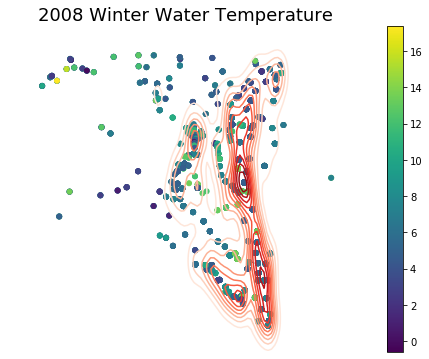

In [130]:
ax3 = gplt.kdeplot(gdf_win_2008,projection=gcrs.AlbersEqualArea(), cmap='Reds')
gplt.pointplot(gdf_win_2008, hue='MeasureValue', legend=True, ax=ax3)
plt.title('2008 Winter Water Temperature', fontsize=18)
plt.savefig("2008 Winter Water Temp.png", bbox_inches='tight', pad_inches=0.1)

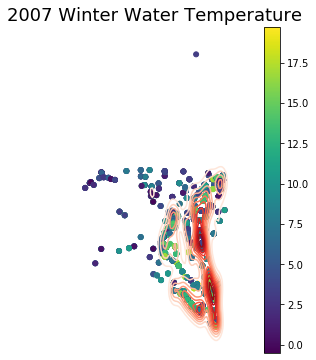

In [131]:
ax4 = gplt.kdeplot(gdf_win_2007,projection=gcrs.AlbersEqualArea(), cmap='Reds')
gplt.pointplot(gdf_win_2007, hue='MeasureValue', legend=True, ax=ax4)
plt.title('2007 Winter Water Temperature', fontsize=18)
plt.savefig("2007 Winter Water Temp.png", bbox_inches='tight', pad_inches=0.1)

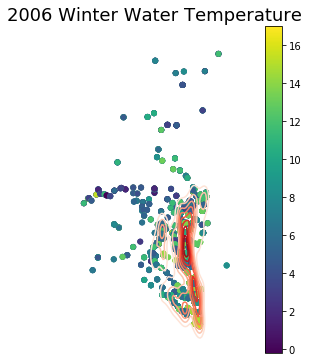

In [132]:
ax5 = gplt.kdeplot(gdf_win_2006,projection=gcrs.AlbersEqualArea(), cmap='Reds')
gplt.pointplot(gdf_win_2006, hue='MeasureValue', legend=True, ax=ax5)
plt.title('2006 Winter Water Temperature', fontsize=18)
plt.savefig("2006 Winter Water Temp.png", bbox_inches='tight', pad_inches=0.1)

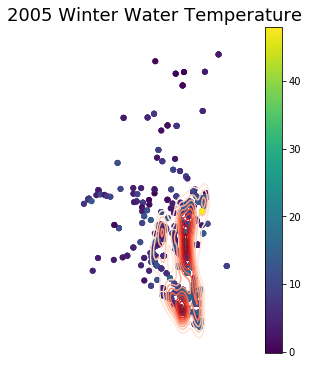

In [133]:
ax6 = gplt.kdeplot(gdf_win_2005,projection=gcrs.AlbersEqualArea(), cmap='Reds')
gplt.pointplot(gdf_win_2005, hue='MeasureValue', legend=True, ax=ax6)
plt.title('2005 Winter Water Temperature', fontsize=18)
plt.savefig("2005 Winter Water Temp.png", bbox_inches='tight', pad_inches=0.1)

In [58]:
summer_2010 = pd.read_excel("water_temp_sub_summer_2010.xlsx")
summer_2009 = pd.read_excel("water_temp_sub_summer_2009.xlsx")
summer_2008 = pd.read_excel("water_temp_sub_summer_2008.xlsx")
summer_2007 = pd.read_excel("water_temp_sub_summer_2007.xlsx")
summer_2006 = pd.read_excel("water_temp_sub_summer_2006.xlsx")
summer_2005 = pd.read_excel("water_temp_sub_summer_2005.xlsx")

In [59]:
gdf_summer_2010 = geopandas.GeoDataFrame(
    summer_2010, geometry=geopandas.points_from_xy(summer_2010.Longitude, \
                                                                  summer_2010.Latitude))

In [60]:
gdf_summer_2009 = geopandas.GeoDataFrame(
    summer_2009, geometry=geopandas.points_from_xy(summer_2009.Longitude, \
                                                                  summer_2009.Latitude))
gdf_summer_2008 = geopandas.GeoDataFrame(
    summer_2008, geometry=geopandas.points_from_xy(summer_2008.Longitude, \
                                                                  summer_2008.Latitude))
gdf_summer_2007 = geopandas.GeoDataFrame(
    summer_2007, geometry=geopandas.points_from_xy(summer_2007.Longitude, \
                                                                  summer_2007.Latitude))
gdf_summer_2006 = geopandas.GeoDataFrame(
    summer_2006, geometry=geopandas.points_from_xy(summer_2006.Longitude, \
                                                                  summer_2006.Latitude))
gdf_summer_2005 = geopandas.GeoDataFrame(
    summer_2005, geometry=geopandas.points_from_xy(summer_2005.Longitude, \
                                                                  summer_2005.Latitude))

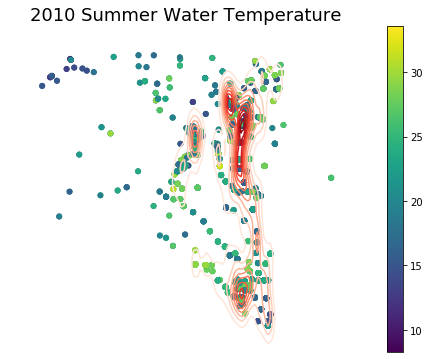

In [137]:
ax1 = gplt.kdeplot(gdf_summer_2010,projection=gcrs.AlbersEqualArea(), cmap='Reds')
gplt.pointplot(gdf_summer_2010, hue='MeasureValue', legend=True, ax=ax1)
plt.title('2010 Summer Water Temperature', fontsize=18)
plt.savefig("2010 Summer Water Temp.png", bbox_inches='tight', pad_inches=0.1)

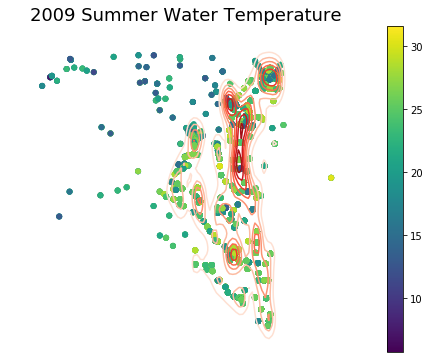

In [138]:
ax1 = gplt.kdeplot(gdf_summer_2009,projection=gcrs.AlbersEqualArea(), cmap='Reds')
gplt.pointplot(gdf_summer_2009, hue='MeasureValue', legend=True, ax=ax1)
plt.title('2009 Summer Water Temperature', fontsize=18)
plt.savefig("2009 Summer Water Temp.png", bbox_inches='tight', pad_inches=0.1)

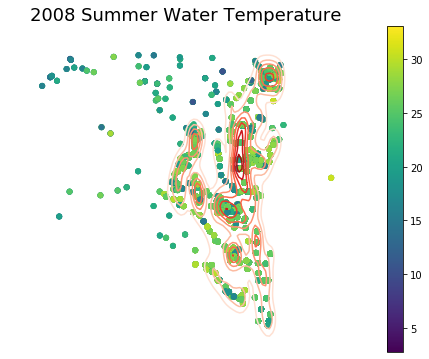

In [139]:
ax1 = gplt.kdeplot(gdf_summer_2008,projection=gcrs.AlbersEqualArea(), cmap='Reds')
gplt.pointplot(gdf_summer_2008, hue='MeasureValue', legend=True, ax=ax1)
plt.title('2008 Summer Water Temperature', fontsize=18)
plt.savefig("2008 Summer Water Temp.png", bbox_inches='tight', pad_inches=0.1)

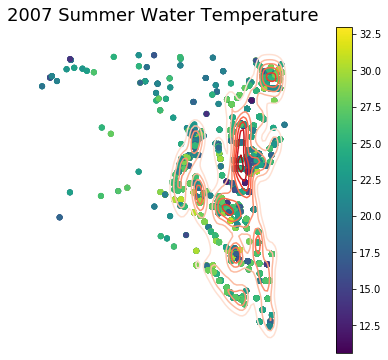

In [140]:
ax1 = gplt.kdeplot(gdf_summer_2007,projection=gcrs.AlbersEqualArea(), cmap='Reds')
gplt.pointplot(gdf_summer_2007, hue='MeasureValue', legend=True, ax=ax1)
plt.title('2007 Summer Water Temperature', fontsize=18)
plt.savefig("2007 Summer Water Temp.png", bbox_inches='tight', pad_inches=0.1)

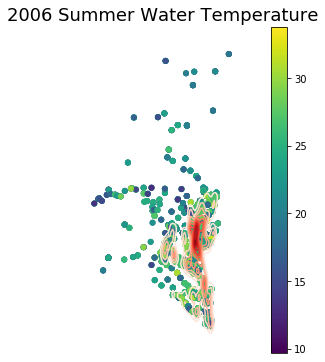

In [141]:
ax1 = gplt.kdeplot(gdf_summer_2006,projection=gcrs.AlbersEqualArea(), cmap='Reds')
gplt.pointplot(gdf_summer_2006, hue='MeasureValue', legend=True, ax=ax1)
plt.title('2006 Summer Water Temperature', fontsize=18)
plt.savefig("2006 Summer Water Temp.png", bbox_inches='tight', pad_inches=0.1)

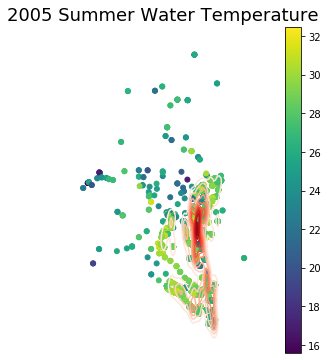

In [142]:
ax1 = gplt.kdeplot(gdf_summer_2005,projection=gcrs.AlbersEqualArea(), cmap='Reds')
gplt.pointplot(gdf_summer_2005, hue='MeasureValue', legend=True, ax=ax1)
plt.title('2005 Summer Water Temperature', fontsize=18)
plt.savefig("2005 Summer Water Temp.png", bbox_inches='tight', pad_inches=0.1)

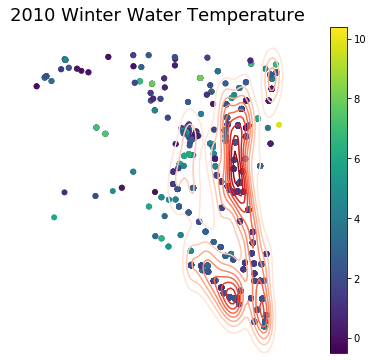

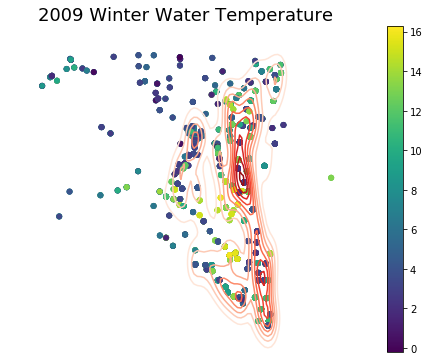

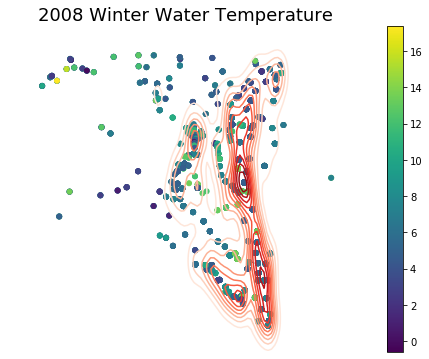

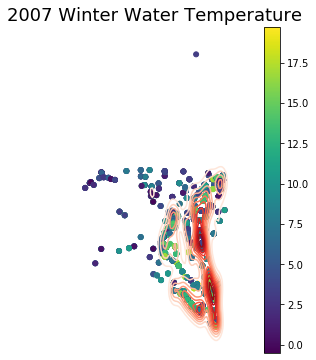

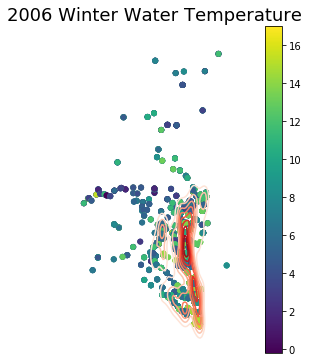

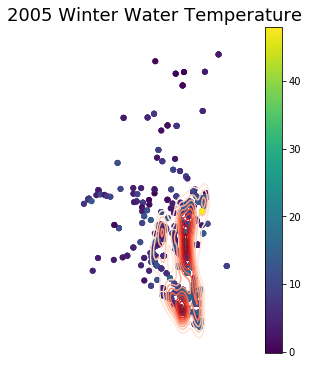

In [124]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7, 7))

ax1 = gplt.kdeplot(gdf,projection=gcrs.AlbersEqualArea(), cmap='Reds')
gplt.pointplot(gdf, hue='MeasureValue', legend=True, ax=ax1)
#plt1.title('2010 Winter Water Temperature', fontsize=18)
ax2 = gplt.kdeplot(gdf_win_2009,projection=gcrs.AlbersEqualArea(), cmap='Reds')
gplt.pointplot(gdf_win_2009, hue='MeasureValue', legend=True, ax=ax2)
plt2.title('2009 Winter Water Temperature', fontsize=18)
ax3 = gplt.kdeplot(gdf_win_2008,projection=gcrs.AlbersEqualArea(), cmap='Reds')
gplt.pointplot(gdf_win_2008, hue='MeasureValue', legend=True, ax=ax3)
plt.title('2008 Winter Water Temperature', fontsize=18)
ax4 = gplt.kdeplot(gdf_win_2007,projection=gcrs.AlbersEqualArea(), cmap='Reds')
gplt.pointplot(gdf_win_2007, hue='MeasureValue', legend=True, ax=ax4)
plt.title('2007 Winter Water Temperature', fontsize=18)
ax5 = gplt.kdeplot(gdf_win_2006,projection=gcrs.AlbersEqualArea(), cmap='Reds')
gplt.pointplot(gdf_win_2006, hue='MeasureValue', legend=True, ax=ax5)
plt.title('2006 Winter Water Temperature', fontsize=18)
ax6 = gplt.kdeplot(gdf_win_2005,projection=gcrs.AlbersEqualArea(), cmap='Reds')
gplt.pointplot(gdf_win_2005, hue='MeasureValue', legend=True, ax=ax6)
plt.title('2005 Winter Water Temperature', fontsize=18)
plt.savefig("2005-2010 Winter Water Temp.png", bbox_inches='tight', pad_inches=0.1)

# plot time signal:
axs[0, 0].set_title("2010 Winter Water Temperature")
axs[0, 0].plot(plt1, color='C0')
#axs[0, 0].set_xlabel("Time")
#axs[0, 0].set_ylabel("Amplitude")

# plot different spectrum types:
axs[1, 0].set_title("Magnitude Spectrum")
axs[1, 0].magnitude_spectrum(s, Fs=Fs, color='C1')

axs[1, 1].set_title("Log. Magnitude Spectrum")
axs[1, 1].magnitude_spectrum(s, Fs=Fs, scale='dB', color='C1')

axs[2, 0].set_title("Phase Spectrum ")
axs[2, 0].phase_spectrum(s, Fs=Fs, color='C2')

axs[2, 1].set_title("Angle Spectrum")
axs[2, 1].angle_spectrum(s, Fs=Fs, color='C2')

axs[0, 1].remove()  # don't display empty ax

fig.tight_layout()
plt.show()





# Time-Series to check whether water temperature is stationary

The AFC and PACF methods and deseasonality methods citation: https://github.com/marbakes/pca-arima-fun/blob/master/Data%20Processing%20%26%20Modeling.ipynb (Marina Baker)

The ACF

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
import seaborn as sns
sns.set()

In [122]:
# resample the time-series as weekly. 
sub_water_temp = sub_water_temp.resample('W').mean().interpolate(method = 'time')

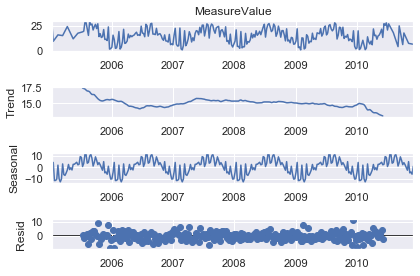

In [123]:
seasonal_decompose(sub_water_temp['MeasureValue']).plot()
plt.show()

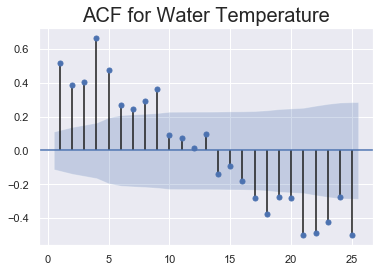

In [125]:
sgt.plot_acf(sub_water_temp.MeasureValue, zero = False) # why the lags set to 52?
plt.title("ACF for Water Temperature", size = 20)
plt.show()

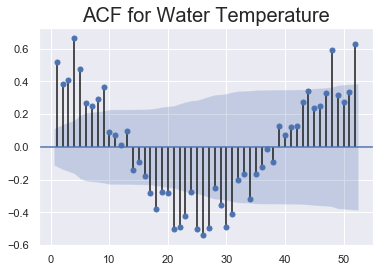

In [126]:
sgt.plot_acf(sub_water_temp.MeasureValue, zero = False, lags = 52) # why the lags set to 52?
plt.title("ACF for Water Temperature", size = 20)
plt.show()

In [55]:
import warnings
warnings.filterwarnings("ignore")

The PACF

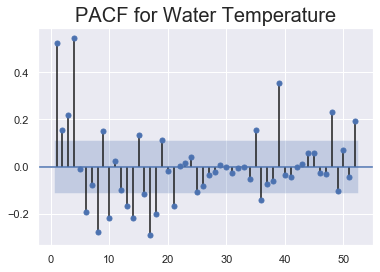

In [127]:
sgt.plot_pacf(sub_water_temp.MeasureValue, lags = 52, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF for Water Temperature", size = 20)
plt.show()

The AR(1) Model

In [128]:
model_ar = ARMA(sub_water_temp.MeasureValue, order=(1,0))

In [129]:
results_ar = model_ar.fit()

In [130]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           MeasureValue   No. Observations:                  309
Model:                     ARMA(1, 0)   Log Likelihood                -990.890
Method:                       css-mle   S.D. of innovations              5.973
Date:                Fri, 04 Sep 2020   AIC                           1987.781
Time:                        17:03:01   BIC                           1998.981
Sample:                    01-09-2005   HQIC                          1992.258
                         - 12-05-2010                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 15.1467      0.710     21.327      0.000      13.755      16.539
ar.L1.MeasureValue     0.5232      0.049     10.755      0.000       0.428       0.619
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9113           +0.0000j            1.9113            0.0000
-----------------------------------------------------------------------------
"""

Higher-Lag AR Models

In [131]:
model_ar_2 = ARMA(sub_water_temp.MeasureValue, order=(2,0))
results_ar_2 = model_ar_2.fit()
results_ar_2.summary() # greater LLR than the AR(1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           MeasureValue   No. Observations:                  309
Model:                     ARMA(2, 0)   Log Likelihood                -987.049
Method:                       css-mle   S.D. of innovations              5.899
Date:                Fri, 04 Sep 2020   AIC                           1982.098
Time:                        17:03:05   BIC                           1997.031
Sample:                    01-09-2005   HQIC                          1988.068
                         - 12-05-2010                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 15.1301      0.830     18.225      0.000      13.503      16.757
ar.L1.MeasureValue     0.4402      0.056      7.793      0.000       0.329       0.551
ar.L2.MeasureValue     0.1580      0.057      2.790      0.005       0.047       0.269
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4827           +0.0000j            1.4827            0.0000
AR.2           -4.2689           +0.0000j            4.2689            0.5000
-----------------------------------------------------------------------------
"""

In [132]:
model_ar_3 = ARMA(sub_water_temp.MeasureValue, order=(3,0))
results_ar_3 = model_ar_3.fit()
results_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           MeasureValue   No. Observations:                  309
Model:                     ARMA(3, 0)   Log Likelihood                -979.326
Method:                       css-mle   S.D. of innovations              5.752
Date:                Fri, 04 Sep 2020   AIC                           1968.652
Time:                        17:03:09   BIC                           1987.319
Sample:                    01-09-2005   HQIC                          1976.115
                         - 12-05-2010                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 15.0818      1.035     14.573      0.000      13.053      17.110
ar.L1.MeasureValue     0.4049      0.056      7.256      0.000       0.296       0.514
ar.L2.MeasureValue     0.0603      0.060      0.997      0.319      -0.058       0.179
ar.L3.MeasureValue     0.2224      0.056      3.982      0.000       0.113       0.332
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2280           -0.0000j            1.2280           -0.0000
AR.2           -0.7495           -1.7604j            1.9133           -0.3141
AR.3           -0.7495           +1.7604j            1.9133            0.3141
-----------------------------------------------------------------------------
"""

In [133]:
model_ar_4 = ARMA(sub_water_temp.MeasureValue, order=[4,0])
results_ar_4 = model_ar_4.fit()
results_ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           MeasureValue   No. Observations:                  309
Model:                     ARMA(4, 0)   Log Likelihood                -924.679
Method:                       css-mle   S.D. of innovations              4.808
Date:                Fri, 04 Sep 2020   AIC                           1861.359
Time:                        17:03:12   BIC                           1883.759
Sample:                    01-09-2005   HQIC                          1870.314
                         - 12-05-2010                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 14.7315      1.857      7.933      0.000      11.092      18.371
ar.L1.MeasureValue     0.2821      0.048      5.909      0.000       0.188       0.376
ar.L2.MeasureValue     0.0281      0.050      0.559      0.576      -0.070       0.127
ar.L3.MeasureValue     0.0013      0.050      0.026      0.979      -0.097       0.100
ar.L4.MeasureValue     0.5487      0.048     11.529      0.000       0.455       0.642
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0515           -0.0000j            1.0515           -0.0000
AR.2            0.0945           -1.1770j            1.1808           -0.2372
AR.3            0.0945           +1.1770j            1.1808            0.2372
AR.4           -1.2430           -0.0000j            1.2430           -0.5000
-----------------------------------------------------------------------------
"""

LLR Test

In [134]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

Comparing Higher-Lag AR Models

In [135]:
LLR_test(model_ar_2, model_ar_3)

0.0

In [136]:
LLR_test(model_ar_3, model_ar_4)

0.0

In [137]:
model_ar_4 = ARMA(sub_water_temp.MeasureValue, order=[4,0])
results_ar_4 = model_ar_4.fit()
print(results_ar_4.summary()) 
print ("LLR test: " + str(LLR_test(model_ar_3, model_ar_4)))

                              ARMA Model Results                              
Dep. Variable:           MeasureValue   No. Observations:                  309
Model:                     ARMA(4, 0)   Log Likelihood                -924.679
Method:                       css-mle   S.D. of innovations              4.808
Date:                Fri, 04 Sep 2020   AIC                           1861.359
Time:                        17:03:28   BIC                           1883.759
Sample:                    01-09-2005   HQIC                          1870.314
                         - 12-05-2010                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 14.7315      1.857      7.933      0.000      11.092      18.371
ar.L1.MeasureValue     0.2821      0.048      5.909      0.000       0.188       0.376
ar.L2.MeasureValue  

In [138]:
model_ar_5 = ARMA(sub_water_temp.MeasureValue, order=(5,0))
results_ar_5 = model_ar_5.fit()
print(results_ar_5.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ar_4, model_ar_5)))

                              ARMA Model Results                              
Dep. Variable:           MeasureValue   No. Observations:                  309
Model:                     ARMA(5, 0)   Log Likelihood                -924.664
Method:                       css-mle   S.D. of innovations              4.808
Date:                Fri, 04 Sep 2020   AIC                           1863.328
Time:                        17:03:42   BIC                           1889.462
Sample:                    01-09-2005   HQIC                          1873.777
                         - 12-05-2010                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 14.7418      1.841      8.007      0.000      11.133      18.350
ar.L1.MeasureValue     0.2876      0.057      5.013      0.000       0.175       0.400
ar.L2.MeasureValue  

In [139]:
model_ar_6 = ARMA(sub_water_temp.MeasureValue, order=(6,0))
results_ar_6 = model_ar_6.fit()
print(results_ar_6.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ar_5, model_ar_6)))

                              ARMA Model Results                              
Dep. Variable:           MeasureValue   No. Observations:                  309
Model:                     ARMA(6, 0)   Log Likelihood                -918.800
Method:                       css-mle   S.D. of innovations              4.716
Date:                Fri, 04 Sep 2020   AIC                           1853.600
Time:                        17:03:51   BIC                           1883.466
Sample:                    01-09-2005   HQIC                          1865.540
                         - 12-05-2010                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 14.8910      1.538      9.683      0.000      11.877      17.905
ar.L1.MeasureValue     0.2844      0.056      5.057      0.000       0.174       0.395
ar.L2.MeasureValue  

In [140]:
model_ar_7 = ARMA(sub_water_temp.MeasureValue, order=(7,0))
results_ar_7 = model_ar_7.fit()
print(results_ar_7.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ar_6, model_ar_7)))

                              ARMA Model Results                              
Dep. Variable:           MeasureValue   No. Observations:                  309
Model:                     ARMA(7, 0)   Log Likelihood                -917.825
Method:                       css-mle   S.D. of innovations              4.701
Date:                Fri, 04 Sep 2020   AIC                           1853.649
Time:                        17:03:58   BIC                           1887.249
Sample:                    01-09-2005   HQIC                          1867.083
                         - 12-05-2010                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 14.9277      1.429     10.444      0.000      12.126      17.729
ar.L1.MeasureValue     0.2682      0.057      4.685      0.000       0.156       0.380
ar.L2.MeasureValue  

In [141]:
model_ar_8 = ARMA(sub_water_temp.MeasureValue, order=(8,0))
results_ar_8 = model_ar_8.fit()
print(results_ar_8.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ar_7, model_ar_8)))

                              ARMA Model Results                              
Dep. Variable:           MeasureValue   No. Observations:                  309
Model:                     ARMA(8, 0)   Log Likelihood                -905.524
Method:                       css-mle   S.D. of innovations              4.513
Date:                Fri, 04 Sep 2020   AIC                           1831.048
Time:                        17:04:06   BIC                           1868.381
Sample:                    01-09-2005   HQIC                          1845.974
                         - 12-05-2010                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 15.0002      1.098     13.664      0.000      12.849      17.152
ar.L1.MeasureValue     0.2451      0.055      4.450      0.000       0.137       0.353
ar.L2.MeasureValue  

In [142]:
model_ar_9 = ARMA(sub_water_temp.MeasureValue, order=(9,0))
results_ar_9 = model_ar_9.fit()
print(results_ar_9.summary())
print("\nLLR test p-value = " + str(LLR_test(model_ar_8, model_ar_9)))

                              ARMA Model Results                              
Dep. Variable:           MeasureValue   No. Observations:                  309
Model:                     ARMA(9, 0)   Log Likelihood                -901.968
Method:                       css-mle   S.D. of innovations              4.460
Date:                Fri, 04 Sep 2020   AIC                           1825.935
Time:                        17:04:44   BIC                           1867.002
Sample:                    01-09-2005   HQIC                          1842.354
                         - 12-05-2010                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 14.9875      1.262     11.875      0.000      12.514      17.461
ar.L1.MeasureValue     0.2887      0.057      5.084      0.000       0.177       0.400
ar.L2.MeasureValue  

In [143]:
print("LLR test: " + str(LLR_test(model_ar, model_ar_8, DF = 7)))

LLR test: 0.0


Analysing the Residuals

In [144]:
sub_water_temp['res_water_temp'] = results_ar_8.resid

In [145]:
sub_water_temp.res_water_temp.mean()

-0.015020086737156477

In [146]:
sub_water_temp.res_water_temp.var()

20.813991273919775

From the ADF test, since P-value is less than .05, we might conclude the time-series is stationary

In [148]:
result = sts.adfuller(sub_water_temp.res_water_temp)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.981860
p-value: 0.001509
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


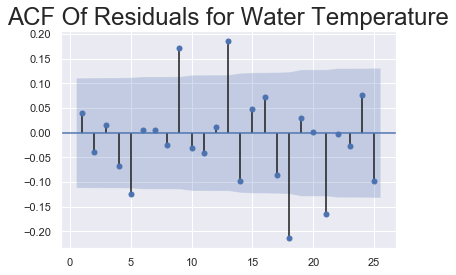

In [149]:
sgt.plot_acf(sub_water_temp.res_water_temp, zero = False)
plt.title("ACF Of Residuals for Water Temperature",size=24)
plt.show()

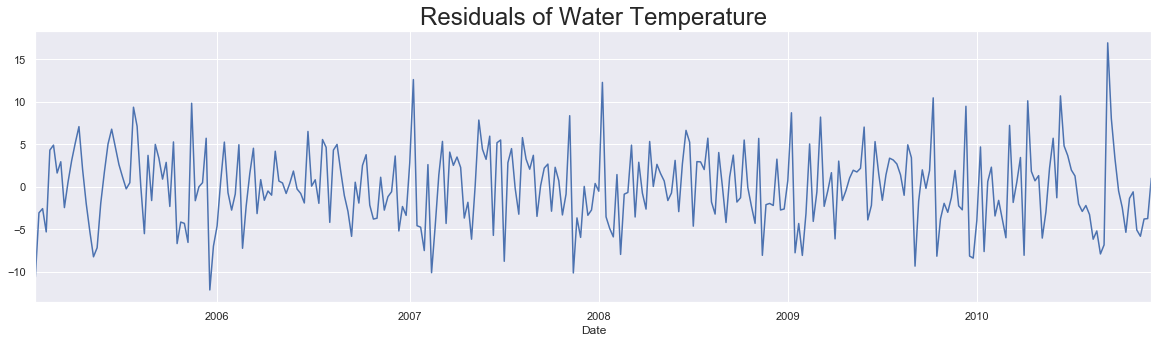

In [150]:
sub_water_temp.res_water_temp[1:].plot(figsize=(20,5))
plt.title("Residuals of Water Temperature",size=24)
plt.show()

2005 - 2010 Water Temperature

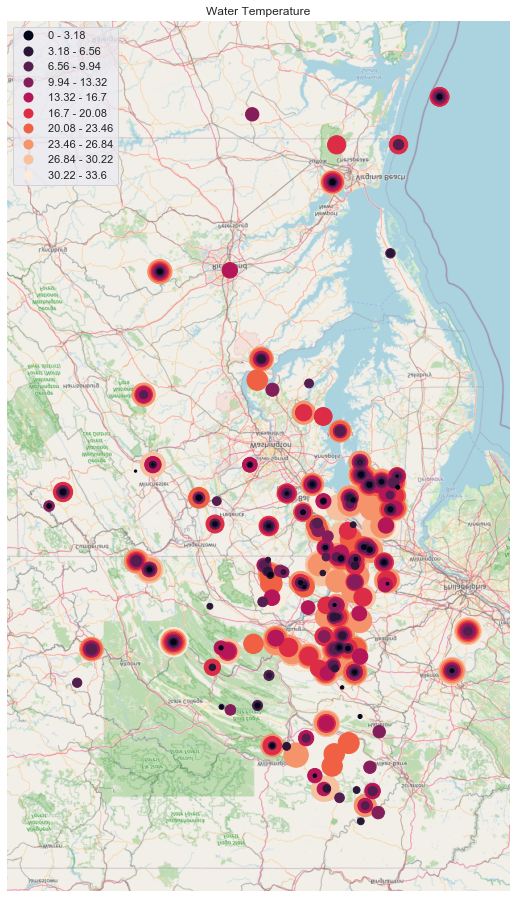

In [303]:
import geoplot.crs as gcrs
ax = gplt.webmap(gdf, figsize = (16, 16), clip=geometry,
    shade=True, cmap='Reds', projection=gcrs.WebMercator())
gplt.pointplot(
    gdf,
    scale='MeasureValue', limits=(2, 30), projection=gcrs.AlbersEqualArea(),
    hue='MeasureValue',
    legend=True,
    scheme=scheme,
#    legend_var='scale',
#    legend_kwargs={'bbox_to_anchor': (1, 0.35), 'frameon': False},
#    legend_values=[0, 5, 10, 15, 20, 25, 30],
#    legend_labels=['0 Degree Celsius', '5 Degree Celsius', '10 Degree Celsius', '15 Degree Celsius', '20 Degree Celsius', \
#                  '25 Degree Celsius','30 Degree Celsius'],
    ax=ax
)
plt.title("Water Temperature")
plt.savefig('Water Temperature Heatmap.png')

Feature Engineering for "Year" and "Season" to have seasonal parameter

# Summer: May - Aug. | Winter: Nov. - Feb.

In [82]:
cmc_water['Date2'] = cmc_water['Date']

In [85]:
cmc_water['Date2'] = cmc_water['Date2'].apply(lambda x: str(x).strip('00:00:00'))

In [87]:
cmc_water['Year'] = cmc_water['Date2'].apply(lambda x: x[:4])

In [98]:
cmc_water['Month'] = cmc_water['Date2'].apply(lambda x: x[:].split('-')[1])

In [99]:
cmc_water['Year'].head()

0    2012
1    2014
2    2014
3    2014
4    2014
Name: Year, dtype: object

In [100]:
cmc_water['Month'].head()

0    01
1    01
2    01
3    01
4    01
Name: Month, dtype: object

In [101]:
cbp_water['Date2'] = cbp_water['Date']

In [102]:
cbp_water['Date2'] = cbp_water['Date2'].apply(lambda x: str(x).strip('00:00:00'))

In [103]:
cbp_water['Year'] = cbp_water['Date2'].apply(lambda x: x[:4])

In [106]:
cbp_water['Month'] = cbp_water['Date2'].apply(lambda x: x[:].split('-')[1])

In [108]:
cbp_water['Year'].unique()

array(['2012', '2014', '2013', '2015', '2011', '2019', '2020', '2018',
       '2016', '2017', '1993', '1994', '2003', '2007', '1997', '1998',
       '1999', '2008', '2009', '2005', '2010', '2001', '2002', '2004',
       '2000', '2006', '1996', '1992'], dtype=object)

In [109]:
cbp_water['Month'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12'], dtype=object)

In [110]:
season = []
for i in range(0, len(cbp_water)):
    if (cbp_water.loc[i]['Month'] == '5') or (cbp_water.loc[i]['Month'] == '6') or (cbp_water.loc[i]['Month'] == '7') or \
    (cbp_water.loc[i]['Month'] == '8'):
        season.append('Summer')
    elif (cbp_water.loc[i]['Month'] == '11') or (cbp_water.loc[i]['Month'] == '12') or (cbp_water.loc[i]['Month'] == '1') \
    or (cbp_water.loc[i]['Month'] == '2'):
        season.append('Winter')
    else:
        season.append('')

In [111]:
cbp_water['Season'] = season

In [117]:
cbp_water.to_excel("new_cbp_seasonal.xlsx", index = False)

In [121]:
cbp_water['Month'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12'], dtype=object)

In [122]:
cmc_water['Month'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12'], dtype=object)

In [132]:
season = []
for i in range(0, len(cbp_water)):
    if (cbp_water.loc[i]['Month'] == '05') or (cbp_water.loc[i]['Month'] == '06') or (cbp_water.loc[i]['Month'] == '07') or \
    (cbp_water.loc[i]['Month'] == '08'):
        season.append('Summer')
    elif (cbp_water.loc[i]['Month'] == '11') or (cbp_water.loc[i]['Month'] == '12') or (cbp_water.loc[i]['Month'] == '01') \
    or (cbp_water.loc[i]['Month'] == '02'):
        season.append('Winter')
    else:
        season.append('')

In [133]:
cbp_water['Season'] = season

In [135]:
cbp_water['Season'].describe()

count     166771
unique         3
top       Summer
freq       76474
Name: Season, dtype: object